In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('../data/SPY.xlsx')
df.columns = df.iloc[5].values
df = df.iloc[6:].iloc[::-1].reset_index(drop=True)
df['Log Return'] = df.PX_LAST.apply(lambda x: np.log(x)).diff()
df.head()

,Date,PX_LAST,Change,% Change,PX_OPEN,Change,% Change,PX_HIGH,Change,% Change,PX_LOW,Change,% Change,Log Return
0,1993-01-29 00:00:00,25.2238,NaN,NaN,25.2417,NaN,NaN,25.2417,NaN,NaN,25.1161,NaN,NaN,NaN
1,1993-02-01 00:00:00,25.4032,NaN,NaN,25.2417,NaN,NaN,25.4032,NaN,NaN,25.2417,NaN,NaN,0.007087
2,1993-02-02 00:00:00,25.457,NaN,NaN,25.3852,NaN,NaN,25.4749,NaN,NaN,25.3314,NaN,NaN,0.002116
3,1993-02-03 00:00:00,25.7261,NaN,NaN,25.4929,NaN,NaN,25.744,NaN,NaN,25.4749,NaN,NaN,0.010515
4,1993-02-04 00:00:00,25.8337,NaN,NaN,25.8158,NaN,NaN,25.8876,NaN,NaN,25.762,NaN,NaN,0.004174


In [3]:
((np.array([1,2,3,4,5,6,7,8]) < np.ones(8) * 2) - 1) * ((np.array([1,2,3,4,5,6,7,8]) < np.ones(8) * 2) - 1)

array([0, 1, 1, 1, 1, 1, 1, 1])

In [8]:
def symmetric(y, beta, q):
    """
    f_t(beta) = b1 + b2 * f_t-1(beta) + b3 * |y_t-1|
    """
    VaR = np.zeros_like(y)
    VaR[0] = np.quantile(y[:300], q)
    
    b1, b2, b3 = beta
    for i in range(1, len(y)):
        VaR[i] = b1 + b2 * VaR[i-1] + b3 * abs(y[i-1])
    
    return VaR

def loss(y, VaR, q):
    dev = y - VaR
    return np.mean(np.maximum(q * dev, (q - 1) * dev))

def sigmoid(x, G):
    """
    mimic indicator function I(x<=0)
    """
    return 1 / (1 + np.exp(G*x))

def derivatives_fbeta(model):
    """
    symmetric:
    asymmetric:
    adaptive:
    igarch:
    """
    if model == 'symmetric':
        pass # -1, - f[t-1]
    elif model == 'asymmetric':
        pass
    elif model == 'adaptive':
        pass
    elif model == 'igarch':
        pass
    else:
        raise ValueError('Wrong Model!')

def get_gradient(y, beta, VaR, q, G):
    """
      d(RQ)/dbeta
    = sum[ (q - sigmoid(y - f(beta))) * d(y - f(beta))/dbeta +
           (y - f(beta)) * d(q - sigmoid(y - f(beta)))/dbeta ]
    """
    gradient = np.zeros_like(beta)
    
    dev = y - VaR
    sigmoid_dev = sigmoid(dev, G)
    for t in range(1, len(y)):
        gradient[0] += (
            (q - sigmoid_dev[t]) * (- 1 - beta[1] * gradient[0]) +
            dev[t] * ((sigmoid_dev[t] - sigmoid_dev[t] ** 2) * G * (- 1 - beta[1] * gradient[0]))
        )
        
        gradient[1] += (
            (q - sigmoid_dev[t]) * (- beta[1] * gradient[1] - VaR[t-1]) +
            dev[t] * ((sigmoid_dev[t] - sigmoid_dev[t] ** 2) * G * (- VaR[t-1] - beta[1] * gradient[1]))
        )
        
        gradient[2] += (
            (q - sigmoid_dev[t]) * (- abs(y[t-1]) - beta[1] * gradient[2]) +
            dev[t] * ((sigmoid_dev[t] - sigmoid_dev[t] ** 2) * G * (- abs(y[t-1]) - beta[1] * gradient[2]))
        )
    return gradient

def gradient_descent(y, q=0.05, G=10, learning_rate=1e-10, max_iter=100, tol=1e-10):
    y = np.array(y)
    beta = np.random.uniform(-1, 1, 3)
    VaR = symmetric(y, beta, q)
    last = loss(y, VaR, q)
    print(f'[0/{max_iter}] Loss: {last:.4f}')
    
    for i in range(max_iter):
        gradient = get_gradient(y, beta, VaR, q, G)
        beta -= learning_rate * gradient
        VaR = symmetric(y, beta, q)
        current = loss(y, VaR, q)
        print(f'[{i+1}/{max_iter}] Loss: {current:.4f} Beta: {beta}')
        if last - current < -np.inf: # tol:
            print('Early stopped.')
            print(f'Final Loss: {current:.4f} Beta: {beta}')
            return beta + learning_rate * gradient
        
        last = current
    
    print(f'Finished {max_iter} loop')
    print(f'Final Loss: {current:.4f}')
    return beta

In [9]:
returns = (df['Log Return'].dropna() - df['Log Return'].dropna().mean()).reset_index(drop=True) * 100

In [10]:
beta = gradient_descent(returns)

[0/100] Loss: 0.5066
[1/100] Loss: nan Beta: [nan nan nan]
[2/100] Loss: nan Beta: [nan nan nan]
[3/100] Loss: nan Beta: [nan nan nan]
[4/100] Loss: nan Beta: [nan nan nan]


<ipython-input-8-2e6d9acb9a0f>:63: RuntimeWarning: overflow encountered in double_scalars
  gradient[2] += (
<ipython-input-8-2e6d9acb9a0f>:63: RuntimeWarning: invalid value encountered in double_scalars
  gradient[2] += (
<ipython-input-8-2e6d9acb9a0f>:53: RuntimeWarning: overflow encountered in double_scalars
  gradient[0] += (
<ipython-input-8-2e6d9acb9a0f>:53: RuntimeWarning: invalid value encountered in double_scalars
  gradient[0] += (
<ipython-input-8-2e6d9acb9a0f>:58: RuntimeWarning: overflow encountered in double_scalars
  gradient[1] += (
<ipython-input-8-2e6d9acb9a0f>:58: RuntimeWarning: invalid value encountered in double_scalars
  gradient[1] += (


[5/100] Loss: nan Beta: [nan nan nan]
[6/100] Loss: nan Beta: [nan nan nan]
[7/100] Loss: nan Beta: [nan nan nan]
[8/100] Loss: nan Beta: [nan nan nan]
[9/100] Loss: nan Beta: [nan nan nan]
[10/100] Loss: nan Beta: [nan nan nan]
[11/100] Loss: nan Beta: [nan nan nan]
[12/100] Loss: nan Beta: [nan nan nan]
[13/100] Loss: nan Beta: [nan nan nan]
[14/100] Loss: nan Beta: [nan nan nan]
[15/100] Loss: nan Beta: [nan nan nan]
[16/100] Loss: nan Beta: [nan nan nan]
[17/100] Loss: nan Beta: [nan nan nan]
[18/100] Loss: nan Beta: [nan nan nan]
[19/100] Loss: nan Beta: [nan nan nan]
[20/100] Loss: nan Beta: [nan nan nan]
[21/100] Loss: nan Beta: [nan nan nan]
[22/100] Loss: nan Beta: [nan nan nan]
[23/100] Loss: nan Beta: [nan nan nan]
[24/100] Loss: nan Beta: [nan nan nan]
[25/100] Loss: nan Beta: [nan nan nan]
[26/100] Loss: nan Beta: [nan nan nan]
[27/100] Loss: nan Beta: [nan nan nan]
[28/100] Loss: nan Beta: [nan nan nan]
[29/100] Loss: nan Beta: [nan nan nan]
[30/100] Loss: nan Beta: [nan 

KeyboardInterrupt: 

0.1899404367968233

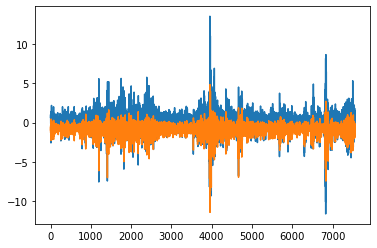

In [205]:
VaR = symmetric(returns, beta, q=0.05)
plt.plot(returns)
plt.plot(VaR)
np.sum(returns < VaR) / len(returns)